<a href="https://colab.research.google.com/github/iupui-soic/pybootcamp/blob/main/Shikhar_Day_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [6]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
some_digit = X[3]
some_digit_image = some_digit.reshape(28, 28)

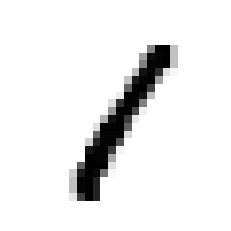

In [17]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [18]:
y[3]

1

It's a string, so converting it into int.

In [8]:
y = y.astype(np.int8)

Splitting the data into test train

In [9]:
X_train, y_train, X_test, y_test = X[:30000], y[:30000], X[30000:], y[30000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30000, 784), (30000,), (40000, 784), (40000,))

MNIST data is already shuffled so no need to do Stratified shuffle

Binary Classifier training

For now, let's make the issue simpler by attempting to identify only one digit (number 5). This "5-detector" is an illustration of a binary classifier; it predicts whether any row will contain 5 or not.

Create the target vector for the classification task:

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)  #taking a fraction of the training data for the notebook to run fast locally

Stochastic Gradient Descent Classifier

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)


In [12]:
sgd_clf.fit(X=X_train, y=y_train_5)


SGDClassifier(n_jobs=-1, random_state=42)

Let's use it to predict the digit of image at index 3:



In [13]:
sgd_clf.predict(X=[some_digit])

array([False])

# Performance Measures


**Cross Validation**

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [15]:
skfolds = StratifiedKFold(n_splits=3, random_state=None)


In [16]:
for train_index, test_index in skfolds.split(X=X_train, y=y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    num_correct = sum(y_pred == y_test_folds)
    print(num_correct / len(y_pred))

0.9458
0.9634
0.9603


Kfold cross validation where k = 3, using cross_val_score() 

In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=clone(sgd_clf), X=X_train, y=y_train_5, cv=5, scoring="accuracy", n_jobs=-1)
scores

array([0.968     , 0.96      , 0.96433333, 0.96266667, 0.9585    ])

It is above 95% which is great.

Performance of a very dumb classifier that classifies all training rows as "Not-5"

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros(shape=(len(X), 1), dtype=bool)

In [19]:
never_5_classifier = Never5Classifier()


In [20]:
scores = cross_val_score(estimator=never_5_classifier, X=X_train, y=y_train_5, cv=5, scoring="accuracy", n_jobs=-1)
scores

array([0.91433333, 0.911     , 0.91016667, 0.90716667, 0.90583333])

Confusion Matrix


In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, n_jobs=-1)


In [22]:
y_train_pred.shape


(30000,)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

array([[26515,   776],
       [  529,  2180]])

In [24]:
y_train_perfect_predictions = y_train_5.copy()

In [25]:
confusion_matrix(y_true=y_train_5, y_pred=y_train_perfect_predictions)

array([[27291,     0],
       [    0,  2709]])

Precision & Recal


In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_true=y_train_5, y_pred=y_train_pred)

0.7374830852503383

In [27]:
recall_score(y_true=y_train_5, y_pred=y_train_pred)

0.8047249907715024

In [29]:
from sklearn.metrics import f1_score
f1_score(y_true=y_train_5, y_pred=y_train_pred)

0.7696381288614299

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-25273.92229748])

In [31]:
threshold = 0

In [32]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
threshold = 8000

In [34]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [35]:
y_scores = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, 
                             cv=3, method='decision_function', n_jobs=-1)

In [36]:
from sklearn.metrics import precision_recall_curve

In [37]:
precision, recall, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores)

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()

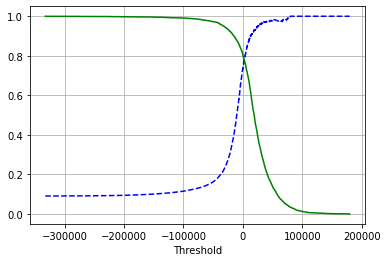

In [39]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()

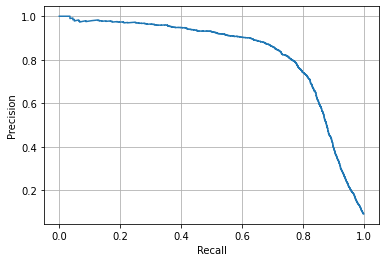

In [40]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [41]:
threshold_90_precision = thresholds[np.argmax(precision > .9)]
threshold_90_precision

12605.39256572511

In [42]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [43]:
precision = precision_score(y_true=y_train_5, y_pred=y_train_pred_90)
precision #predicting precision and recall

0.9003181336161188

In [44]:
recall = recall_score(y_train_5, y_train_pred_90)
recall

0.6267995570321152

there is low recall, so high precision classifier is not good

ROC Curve

In [45]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true=y_train_5, y_score=y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--', label='Random')
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

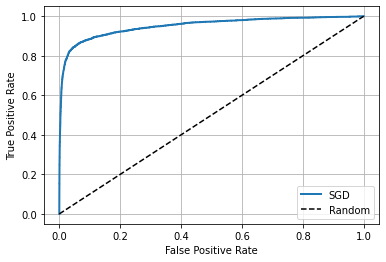

In [46]:
plot_roc_curve(fpr, tpr, label='SGD')
plt.legend(loc='lower right')
plt.show()

In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9509867800410808

Training a Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                    y=y_train_5, cv=5, 
                                    n_jobs=-1, method='predict_proba')

In [48]:
y_scores_forest = y_probas_forest[:, 1]


In [49]:
fpr_forest, tps_forest, threshs_forest = roc_curve(y_true=y_train_5, y_score=y_scores_forest)

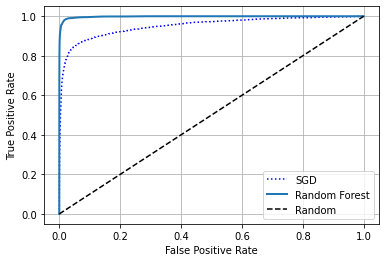

In [50]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tps_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

In [54]:
roc_auc_score(y_train_5, y_scores_forest) #area undewr the curve

0.998160698309738

In [52]:
y_preds_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                   y=y_train_5, cv=5, 
                                   n_jobs=-1)

In [55]:
precision_score(y_true=y_train_5, y_pred=y_preds_forest)

0.989659629470056

In [56]:
recall_score(y_true=y_train_5, y_pred=y_preds_forest)

0.8479143595422666

Multiclass Classification


In [57]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC()
X_train.shape, y_train.shape

((30000, 784), (30000,))

In [58]:
svm_clf.fit(X=X_train, y=y_train)
svm_clf.predict([some_digit])


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([1], dtype=int8)

In [59]:
some_digit_scores = svm_clf.decision_function(X=[some_digit])
some_digit_scores

array([[-2.52594035,  1.02710018, -1.16483736, -0.36485763, -3.48987551,
        -2.12713575, -4.00008537, -3.56222774, -1.22044215, -2.59268108]])

In [60]:
np.argmax(some_digit_scores)

1

In [61]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [62]:
svm_clf.classes_[np.argmax(some_digit_scores)]

1

In [63]:
from sklearn.multiclass import OneVsRestClassifier

In [64]:
ovr_clf = OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

In [65]:
ovr_clf.fit(X=X_train, y=y_train)

OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

In [66]:
ovr_clf.predict([some_digit])

array([1], dtype=int8)

In [67]:
len(ovr_clf.estimators_)

10

In [68]:
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

In [69]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(n_jobs=-1, random_state=42)

In [70]:
sgd_clf.predict([some_digit])

array([1], dtype=int8)

In [71]:
sgd_clf.decision_function([some_digit])

array([[-25394.07068724,  27108.93464498,  -5756.08967224,
        -16280.61824375, -27918.26974832, -26582.50301493,
        -64218.45094131, -40435.29444704, -10211.88830565,
        -23993.16836397]])

In [72]:
cross_val_score(estimator=sgd_clf, X=X_train, y=y_train, cv=5, scoring='accuracy', n_jobs=-1)
#evaluating the performance of our classifiers using cross-validation

array([0.88366667, 0.864     , 0.86916667, 0.87766667, 0.8725    ])

In [ ]:
#scaling the input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X=X_train.astype(np.float64))
cross_val_score(estimator=sgd_clf, X=X_train_scaled, y=y_train, scoring='accuracy', cv=5, n_jobs=-1)